# Модельный эксперимент с использованием BigARTM Python API.

BigARTM &ndash; открытая библиотека для тематического моделирования текстовых коллекций, реализующая теорию аддитивной регуляризации тематических моделей (ARTM). Основной сайт проекта http://bigartm.org/.

Здесь показан пример использования пользовательского Python API библиотеки. Мы проведём демонстрационный эксперимент.

#### Описание:
Построим две тематические модели коллекции текстовых документов, ARTM и PLSA, сравним качество полученных моделей.

#### Функционалы качества:
Важным функционалом является перплексия коллекции. Тем не менее, это далеко не единственная величина, характеризующая качество обучения. В BigARTM реализованы следующие функционалы:

- разреженность матрицы $\Phi$ (слова-темы);
- разреженность матрицы $\Theta$ (темы-документы);
- характеристики ядер тем (чистота, контрастность, размер);
- перплексия;
- веса тем;
- доля фоновых слов;
- когерентность топ-слов и слов из ядер тем.

Мы будем использовать первые четыре. Более сильные разреженности матриц и более высокие средние значения чистоты и контрастности способствуют большей интерпретируемости модели.

#### Цель эксперимента:
Попробуем обучить модель ARTM таким образом, чтобы, в сравнении с PLSA, улучшить значения разреженностей и ядровых характеристик и не сильно ухудшить перплексию.

Основным инструментом для корректирования процесса обучения являются регуляризаторы. Список имеющихся в BigARTM регуляризаторов:

- разреживание матрицы $\Phi$ (+ частичное обучение);
- разреживание матрицы $\Theta$ (+ частичное обучение);
- декоррелирование тем в матрице $\Phi$;
- принудительное разреживание $\Phi$;
- балансирование классов (Label Regularization);
- повышение когерентности.

В этом эксперименте для обучения ARTM воспользуемся первыми тремя регуляризаторами. ARTM без регуляризации соответствует PLSA.

#### Коллекция:
Воспользуемся небольшой коллекцией 'kos', доступной в репозитории UCI https://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/. Параметры коллекции следующие:

- 3430 документов;
- 6906 слов в словаре;
- 467714 ненулевых счётчиков в "мешке слов".

Для начала подключим все необходимые модули (убедитесь, что путь к Python API BigARTM находится в вашей переменной PATH):

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

Прежде всего необходимо подготовить входные данные. BigARTM имеет собственный формат документов для обработки, называемый батчами. В библиотеке присутствуют средства по созданию батчей из файлов в форматах Bag-Of-Words UCI и Vowpal Wabbit (подробности можно найти в http://docs.bigartm.org/en/latest/formats.html).

В Python API, по аналогии с алгоритмами из scikit-learn, входные данные представлены одним классом BatchVectorizer. Объект этого класса принимает на вход батчи или файлы UCI / VW и подаётся на вход всем методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

Итак, создадим объект BatchVectorizer:

In [2]:
batch_vectorizer = None
if len(glob.glob(os.path.join('kos', '*.batch'))) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci', collection_name='kos', target_folder='kos')
else:
    batch_vectorizer = artm.BatchVectorizer(data_path='kos', data_format='batches')

ARTM &ndash; это класс, представляющий собой Python API BigARTM, и позволяющий использовать практически все возможности библиотеки в стиле scikit-learn. Создадим две тематические модели для нашего эксперимента. Наиболее важным параметром модели является число тем. Опционально можно указать списки регуляризаторов и функционалов качества, которые следует использовать для данной модели. Если этого не сделать, то регуляризаторы и функционалы всегда можно добавить позднее. Обратите внимание, что каждая модель задаёт своё пространство имён для названий регуляризаторов и функционалов качества.

In [3]:
dictionary = artm.Dictionary()

model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in xrange(15)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    use_unigram_document_model=False,
                                                    dictionary=dictionary)],
                       cache_theta=True)

model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in xrange(15)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    use_unigram_document_model=False,
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)],
                       cache_theta=True)

Следующий шаг — инициализация моделей. Сделаем это по словарю, что означает, что
- будет создана матрица $\Phi$ с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эта матрица будет заполнена случайными значениями из диапазона (0, 1) и нормализована.

Надо отметить, что этот шаг является опциональным, поскольку модель может быть автоматически инициализирована во время вызовов fit_offline() / fit_online().

Словарь &ndash; это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.

In [4]:
if not os.path.isfile('kos/dictionary.dict'):
    dictionary.gather(data_path=batch_vectorizer.data_path)
    dictionary.save(dictionary_path='kos/dictionary.dict')

dictionary.load(dictionary_path='kos/dictionary.dict')
dictionary.load(dictionary_path='kos/dictionary.dict')

Затем словари можно использовать, чтобы инициализировать модель:

In [5]:
model_plsa.initialize(dictionary=dictionary)
model_artm.initialize(dictionary=dictionary)

Как уже было сказано, ARTM предоставляет возможность использовать все функционалы качества, имеющиеся в BigARTM. Если функционал подключен к модели, то модель будет сохранять все его значения, полученные на момент каждого обновления матрицы $\Phi$. Добавим функционалы качества, нужные для нашего эксперимента, которые отсутствовали в конструкторах:

In [6]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

Аналогично поступим с регуляризаторами для model_artm (зададим им стартовые коэффициенты регуляризации, которые можно будет позже изменить при необходимости):

In [7]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

Теперь попробуем обучить модели в оффлайн-режиме (т.е. обновляя Фи раз за проход по коллекции). Инициируем пятнадцать проходов:

In [8]:
model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Проверим результаты первой итерации обучения, сравнив финальные значения функционалов, а также графики перплексии (опишем печать в виде функции для возможности повторного использования):

Sparsity Phi: 0.000 (PLSA) vs. 0.469 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.001 (ARTM)
Kernel contrast: 0.466 (PLSA) vs. 0.525 (ARTM)
Kernel purity: 0.215 (PLSA) vs. 0.359 (ARTM)
Perplexity: 2058.027 (PLSA) vs. 1950.717 (ARTM)


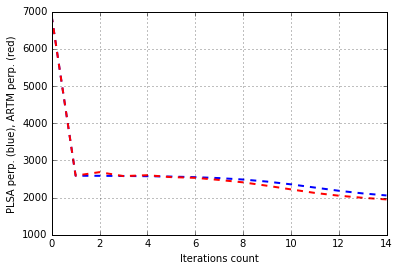

In [9]:
def print_measures(model_plsa, model_artm):
    print 'Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value)

    print 'Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value)

    print 'Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast)

    print 'Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity)

    print 'Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value)

    plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             xrange(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_plsa, model_artm)

Видно, что улучшения разреженностей и ядровых характеристик есть, а ухудшение перплексии невелико. Попробуем увеличить по модулю значения коэффициентов регуляризации при регуляризаторах:

In [10]:
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -0.2
model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

Кроме того, подключим к каждой из моделей функционал TopTokensScore, который позволит взглянуть на самые вероятные слова в каждой теме:

In [11]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

Продолжим обучение моделей, инициировав 25 проходов по коллекции, после чего снова посмотрим на значения функционалов качества:

In [12]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

Sparsity Phi: 0.093 (PLSA) vs. 0.841 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.023 (ARTM)
Kernel contrast: 0.640 (PLSA) vs. 0.740 (ARTM)
Kernel purity: 0.674 (PLSA) vs. 0.822 (ARTM)
Perplexity: 1619.031 (PLSA) vs. 1644.220 (ARTM)


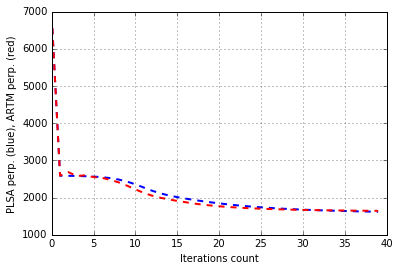

In [13]:
print_measures(model_plsa, model_artm)

Кроме того, для наглядности построим графики изменения разреженностей матриц по итерациям:

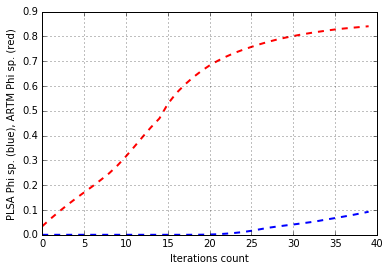

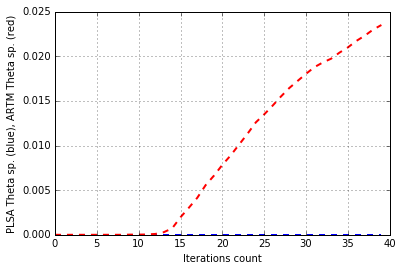

In [14]:
plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
                 xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
                 xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

Кажется, что достигнутых результатов достаточно. Регуляризация позволила добиться улучшения всех характеристик, ухудшив перплексию в пределах разумного. Взглянем на топ-слова слова моделей:

In [15]:
for topic_name in model_plsa.topic_names:
    print topic_name + ': ',
    print model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name]

topic_0:  [u'year', u'tax', u'jobs', u'america', u'president', u'issues']
topic_1:  [u'people', u'war', u'service', u'military', u'rights', u'vietnam']
topic_2:  [u'november', u'electoral', u'account', u'polls', u'governor', u'contact']
topic_3:  [u'republican', u'gop', u'senate', u'senator', u'south', u'conservative']
topic_4:  [u'people', u'time', u'country', u'speech', u'talking', u'read']
topic_5:  [u'dean', u'democratic', u'edwards', u'primary', u'kerry', u'clark']
topic_6:  [u'state', u'party', u'race', u'candidates', u'candidate', u'elections']
topic_7:  [u'administration', u'president', u'years', u'bill', u'white', u'cheney']
topic_8:  [u'campaign', u'national', u'media', u'local', u'late', u'union']
topic_9:  [u'house', u'million', u'money', u'republican', u'committee', u'delay']
topic_10:  [u'republicans', u'vote', u'senate', u'election', u'democrats', u'house']
topic_11:  [u'iraq', u'war', u'american', u'iraqi', u'military', u'intelligence']
topic_12:  [u'kerry', u'poll', u'

In [16]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]

topic_0:  [u'party', u'political', u'issue', u'tax', u'america', u'issues']
topic_1:  [u'people', u'military', u'official', u'officials', u'service', u'public']
topic_2:  [u'electoral', u'governor', u'account', u'contact', u'ticket', u'experience']
topic_3:  [u'gop', u'convention', u'senator', u'debate', u'south', u'sen']
topic_4:  [u'country', u'speech', u'bad', u'read', u'end', u'talking']
topic_5:  [u'democratic', u'dean', u'john', u'edwards', u'primary', u'clark']
topic_6:  [u'percent', u'race', u'candidates', u'candidate', u'win', u'nader']
topic_7:  [u'administration', u'years', u'white', u'year', u'bill', u'jobs']
topic_8:  [u'campaign', u'national', u'media', u'press', u'local', u'ads']
topic_9:  [u'house', u'republican', u'million', u'money', u'elections', u'district']
topic_10:  [u'november', u'poll', u'senate', u'republicans', u'vote', u'election']
topic_11:  [u'iraq', u'war', u'american', u'iraqi', u'security', u'united']
topic_12:  [u'bush', u'kerry', u'general', u'preside

Видно, что темы примерно одинаково интерпретируемы, но в модели ARTM они существенно разнообразнее.

Извлечём матрицу $\Phi$ в виде pandas.DataFrame и напечатаем её (в случае необходимости, можно извлекать части матрицы с помощью метода ARTM.get_phi()):

In [17]:
print model_artm.phi_

                   topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
parentheses       0.000000  0.000000  0.000000  0.000000  0.000000  0.000277   
opinion           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
attitude          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
held              0.000000  0.000385  0.000000  0.000000  0.000000  0.000000   
impeachment       0.000000  0.000115  0.000000  0.000000  0.000000  0.000000   
platform          0.001717  0.000000  0.000000  0.000000  0.000000  0.000000   
msnbc             0.000000  0.000000  0.000000  0.000000  0.000000  0.000194   
assault           0.000000  0.000000  0.000000  0.000000  0.001202  0.000000   
tools             0.000000  0.000000  0.000000  0.000000  0.000502  0.000000   
vance             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
contingent        0.000000  0.000544  0.000000  0.000000  0.000000  0.000000   
drove             0.000000  0.000146  0.

Модель можно сохранить с возможностью последующей загрузки:

In [18]:
model_artm.save(filename='kos_artm_model')  # save the model to disk

# model = artm.ARTM(topic_names=[])                    # create new model
# model.load(filename='kos_artm_model')     # load saved model into new instance

Дополнительно извлечём $\Theta$ в виде pandas.DataFrame и напечатаем её:

In [19]:
theta_matrix = model_artm.get_theta()
print theta_matrix

              3001      3002      3003      3004      3005      3006  \
topic_0   0.076121  0.035934  0.069378  0.136764  0.083617  0.011377   
topic_1   0.095387  0.029030  0.034951  0.043516  0.064787  0.022496   
topic_2   0.004087  0.048284  0.012102  0.006649  0.015708  0.520682   
topic_3   0.057739  0.029823  0.122427  0.085727  0.060414  0.016142   
topic_4   0.122659  0.046273  0.084217  0.077540  0.064804  0.014840   
topic_5   0.025646  0.010737  0.024132  0.051743  0.059580  0.017807   
topic_6   0.044074  0.017331  0.072042  0.042680  0.036825  0.017084   
topic_7   0.061899  0.059855  0.022353  0.029254  0.002857  0.005222   
topic_8   0.049225  0.048494  0.043635  0.095823  0.025636  0.016371   
topic_9   0.070107  0.492084  0.014166  0.131112  0.200206  0.025601   
topic_10  0.056218  0.023523  0.158903  0.092290  0.059759  0.239756   
topic_11  0.158816  0.031754  0.028020  0.024615  0.041939  0.006004   
topic_12  0.054255  0.027387  0.191633  0.078728  0.125391  0.05

Можно использовать модель для определения векторов $\theta_d$ для новых документов с помощью метода ARTM.transform():

In [20]:
test_batch_vectorizer = artm.BatchVectorizer(data_format='batches', data_path='kos_test', batches=['test_docs.batch'])
test_theta_matrix = model_artm.transform(batch_vectorizer=test_batch_vectorizer)
print test_theta_matrix

Empty DataFrame
Columns: []
Index: []


#### Выводы

Задача построения тематической модели имеет бесконечно большое множество решений. Это даёт большую свободу действий, и регуляризаторы позволяют использовать её для получения результата, удовлетворяющего сразу нескольким требованиям (разреженность, интерпретируемость, удовлетворительное значение перплексии и т.п.).

Приведённый выше пример является демонстрационным, можно пробовать более гибкие стратегии регуляризации для получения ещё более хорошего результата. По аналогичной схеме можно производить эксперименты с более крупными коллекциями.